# Quote Extraction Pipeline Visualization

This notebook loads the JSONL outputs from each stage of the quote extraction pipeline, combines them into a single DataFrame, and provides visualizations to analyze the process.

In [1]:
import os
import sys
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Add project root to sys.path to allow for local module imports
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(f"pandas version: {pd.__version__}")
print(f"matplotlib version: {matplotlib.__version__}")

sns.set_theme(style="whitegrid")

pandas version: 2.3.0
matplotlib version: 3.10.3


## 1. Configuration & Parameters

Define paths to the data files and set visualization parameters.

In [2]:
from pathlib import Path

# The `run_extraction.py` script saves the data in a `data` directory at the project root.
DATA_DIR = Path("../../data")
FILES = {
    0: DATA_DIR / "stage0_raw.jsonl",
    1: DATA_DIR / "stage1_cleaner.jsonl",
    2: DATA_DIR / "stage2_extractor.jsonl",
    3: DATA_DIR / "stage3_attributor.jsonl",
    4: DATA_DIR / "stage4_reranker.jsonl"
}

# Visualization settings
SCORE_NULL_PLACEHOLDER = -1.0

## 2. Utility Functions

Helper functions to load and prepare the data for analysis.

In [3]:
def load_stage(stage: int) -> pd.DataFrame:
    """Loads a single stage's JSONL file into a DataFrame."""
    file_path = FILES[stage]
    if not file_path.exists():
        print(f"Warning: File not found for stage {stage} at {file_path}. Please run `make run` first.")
        return pd.DataFrame()
    return pd.read_json(file_path, lines=True)

def prepare_dataframe(dfs: list[pd.DataFrame]) -> pd.DataFrame:
    """Concatenates, cleans, and sorts the DataFrames from all stages."""
    if not any(not df.empty for df in dfs):
        return pd.DataFrame()
    full = pd.concat(dfs, ignore_index=True)
    full["speaker"] = full["speaker"].fillna("<none>")
    full["score"] = full["score"].fillna(SCORE_NULL_PLACEHOLDER)
    return full.sort_values(["stage", "speaker", "score"], ascending=[True, True, False])

## 3. Data Loading & Preparation

Load data from all four stages into a single pandas DataFrame.

In [4]:
dfs = [load_stage(s) for s in FILES]
full_df = prepare_dataframe(dfs)

if not full_df.empty:
    print("Combined DataFrame shape:", full_df.shape)
    display(full_df.head(10))
else:
    print("DataFrame is empty. Please run `make run` first to generate the data.")

Combined DataFrame shape: (151, 7)


,doc_id,stage,text,context,speaker,score,urls
0,mock,0,Case 1:19-cv-02184-TJK Document 5-9 Filed 07/2...,NaN,<none>,-1.0,[]
1,mock,1,Case 1:19-cv-02184-TJK Document 5-9 Filed 07/2...,NaN,<none>,-1.0,[]
2,mock,2,"""as part of [WhatsApp's] plans to test ways fo...",Marc Rotenberg to FTC Comm'r Christine\nVarney...,<none>,0.0,[http://epic.org/privacy/internet/ftc/ftc_lett...
3,mock,2,"""plan[s] to share some information with\nFaceb...",ftc.gov/en forcementlcasesproceedings/092-3184...,<none>,0.0,[https://www.epic.org/ftc/WhatsApp-Complaint.p...
4,mock,2,"""the phone number [users]\nverified when [they...",ftc.gov/en forcementlcasesproceedings/092-3184...,<none>,0.0,[https://www.epic.org/ftc/WhatsApp-Complaint.p...
5,mock,2,"""[t]hat's nearly one in seven people on Earth ...","\n6\nKatherine C. Montgomery, Generation Digit...",<none>,0.0,[http://mitpress.mit.edu/books/generation-digi...
6,mock,2,"""friend suggestions and more relevant ads on F...",\n\nEPIC - CDD Complaint ...,<none>,0.0,[http://www.mobilemarketer.com/cms/news/legalp...
7,mock,2,"""WhatsApp Updated Privacy\nPolicy""","Facebook, Inc. is an American company incorpor...",<none>,0.0,[http://www.mobilemarketer.com/cms/news/legalp...
8,mock,2,"""personal information""","\n9\nPress Release, Federal Trade Comm'n, FTC ...",<none>,0.0,[http://www.ftc.gov/news-events/press-releases...
9,mock,2,"""Facebook and the other companies in the Faceb...",\n\nEPIC - CDD Complaint ...,<none>,0.0,[https://www.whatsapp.com/faq/general/28030012...


## 4. Stage-By-Stage Inspection

Let's examine the output of each pipeline stage. We'll print a formatted summary of the quotes found at each step.

In [5]:
def print_stage_overview(df):
    """Iterates through the dataframe and prints a formatted summary."""
    if df.empty:
        print("No data to display.")
        return
    
    for stage, stage_df in df.groupby("stage"):
        print(f"\n\n{'='*10} Stage {stage} {'='*10}")
        for speaker, grp in stage_df.groupby("speaker"):
            print(f"\n-- Speaker: {speaker!r} ({len(grp)} rows) --")
            # Sort by score for display purposes and show top 5
            for _, row in grp.sort_values('score', ascending=False).head(5).iterrows():
                score_str = f"[{row.score:.2f}]" if row.score >= 0 else "[---]"
                # For raw text, show a snippet
                display_text = str(row.text).replace('\n', ' ')
                if len(display_text) > 120:
                    display_text = display_text[:117] + '...'
                print(f"  • {score_str} {display_text}")

print_stage_overview(full_df)



========== Stage 0 ==========

-- Speaker: '<none>' (1 rows) --
  • [---] Case 1:19-cv-02184-TJK Document 5-9 Filed 07/26/19 Page 1 of 28                     Exhibit 8      Case 1:19-cv-0218...


========== Stage 1 ==========

-- Speaker: '<none>' (1 rows) --
  • [---] Case 1:19-cv-02184-TJK Document 5-9 Filed 07/26/19 Page 1 of 28  Exhibit 8       Case 1:19-cv-02184-TJK Document 5-9 ...


========== Stage 2 ==========

-- Speaker: '<none>' (83 rows) --
  • [0.00] "as part of [WhatsApp's] plans to test ways for people to communicate with businesses in the months ahead. "
  • [0.00] "70  51. The Commission has previously found that retroactive application of materially changed privacy policies to p...
  • [0.00] "The test is whether the consumer's interpretation or  customer phone records without the consumers' authorization ca...
  • [0.00] "68 Sellers may not withhold from consumers important price or performance information, engage in coercion, or unduly...
  • [0.00] "67 This fac

## 5. Cross-Stage Comparison & Visualizations

Now let's visualize the filtering process across stages.

### 5.1 Quote Survival Rate by Stage

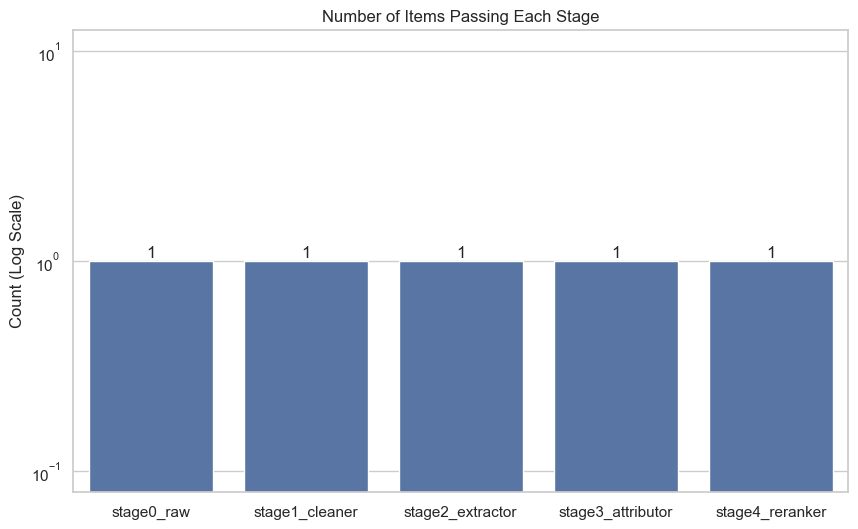

In [6]:
if not full_df.empty:
    stage_counts = full_df.groupby('stage')['doc_id'].nunique()
    stage_labels = {0: 'stage0_raw', 1: 'stage1_cleaner', 2: 'stage2_extractor', 3: 'stage3_attributor', 4: 'stage4_reranker'}
    labels = [stage_labels.get(s, str(s)) for s in stage_counts.index]
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=labels, y=stage_counts.values)
    ax.set_title('Number of Items Passing Each Stage')
    ax.set_ylabel('Count (Log Scale)')
    ax.set_yscale('log')
    ax.bar_label(ax.containers[0])
    plt.show()
else:
    print("No data to plot.")

### 5.2 Speaker Distribution in Final Stage

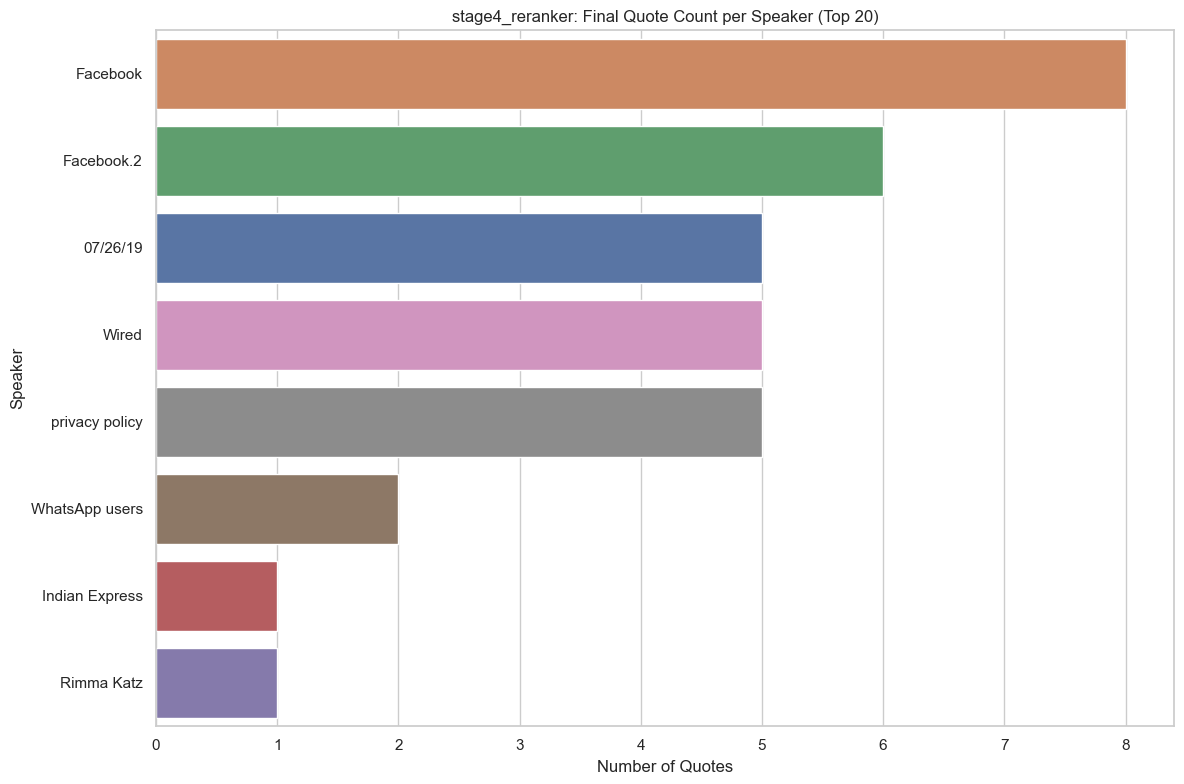

In [7]:
if not full_df.empty:
    final_df = full_df[full_df.stage == 4]
    if not final_df.empty:
        plt.figure(figsize=(12, 8))
        top_speakers = final_df['speaker'].value_counts().nlargest(20).index
        speaker_df = final_df[final_df['speaker'].isin(top_speakers)]
        ax = sns.countplot(y=speaker_df['speaker'], order=top_speakers, hue=speaker_df['speaker'], legend=False)
        ax.set_title('stage4_reranker: Final Quote Count per Speaker (Top 20)')
        ax.set_xlabel('Number of Quotes')
        ax.set_ylabel('Speaker')
        plt.tight_layout()
        plt.show()
    else:
        print("No quotes survived to the final stage.")
else:
    print("No data to plot.")

### 5.3 Score Distribution in Final Stage

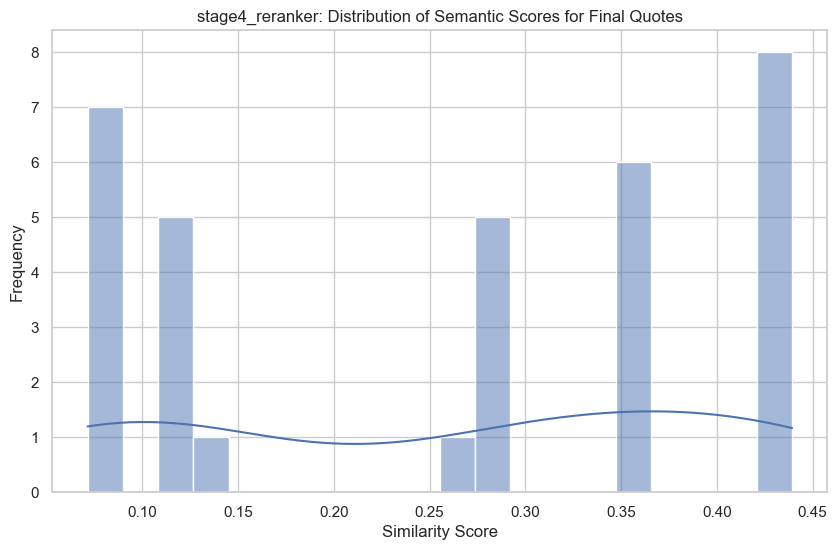

In [8]:
if not full_df.empty:
    final_df_with_scores = full_df[(full_df.stage == 4) & (full_df.score >= 0)]
    if not final_df_with_scores.empty:
        plt.figure(figsize=(10, 6))
        ax = sns.histplot(final_df_with_scores['score'], bins=20, kde=True)
        ax.set_title('stage4_reranker: Distribution of Semantic Scores for Final Quotes')
        ax.set_xlabel('Similarity Score')
        ax.set_ylabel('Frequency')
        plt.show()
    else:
        print("No scored quotes in the final stage to plot.")
else:
    print("No data to plot.")

## 6. Conclusion

This notebook provides a detailed, stage-by-stage analysis of the quote extraction pipeline. The visualizations highlight the filtering effectiveness at each step, from raw text to final, semantically-scored quotes.